# Import Packages

In [1]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Text pre-processing
import re
import gensim
from gensim.parsing.porter import PorterStemmer
stop_list = gensim.parsing.preprocessing.STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

# for fuzzy matching of company names
from rapidfuzz import process, fuzz

# for removal of role phrases
from flashtext import KeywordProcessor

# for saving and loading data
import pickle

# Import Data

In [3]:
current_directory = os.getcwd()
print("Current working directory:", current_directory)

Current working directory: C:\Users\TYY\Desktop\MITB Modules\ISSS609 Text Analytics\Group Project\Doc Retrieval


In [5]:
data_directory = os.path.join(current_directory, 'data')
print("Input data directory:", data_directory)

Input data directory: C:\Users\TYY\Desktop\MITB Modules\ISSS609 Text Analytics\Group Project\Doc Retrieval\data


In [7]:
output_directory = os.path.join(current_directory, 'output')
print("Output data directory:", output_directory)

Output data directory: C:\Users\TYY\Desktop\MITB Modules\ISSS609 Text Analytics\Group Project\Doc Retrieval\output


In [9]:
# Read processed data
job_path = os.path.join(data_directory, 'data_cleaned_1.csv')
jobs_df = pd.read_csv(job_path)

In [11]:
# Drop 6 records where description is all Chinese (resulting in NA after cleaning)
jobs_df = jobs_df.dropna(subset=["processed_title+desc"])
print(jobs_df.isna().sum())

job_id                      0
job_title                   0
company                     0
descriptions                0
State                       0
merged_category             0
category                    0
subcategory                 0
role_clean                  0
type_clean                  0
salary                  35496
processed_title+desc        0
processed_text              0
dtype: int64


In [13]:
# convert "type_clean" into list
jobs_df["type_clean"] = jobs_df["type_clean"].str.lower().str.split(", ").apply(list)

# Clean `company` Field and Create Gazatteer (`companies`)
The cleaned `company_clean` field will be part of the jobs_df data for filtering later after matches are found  
The deduplicated `company_clean` values will become the gazatteer (`companies`)

In [15]:
def normalize_text_company(text):
    text = text.lower()                                    # lowercase
    text = re.sub(r'\([^)]*\)|\[[^\]]*\]', "", text)       # remove text within parenthesis or square brackets
    text = re.sub(r'&', 'and', text)                       # convert & to and
    text = re.sub(r'malaysia|sdn|bhd|sb| s b|berhad|pte|plt|pty|group|holdings|co\.|ltd\.| ltd', '', text).strip()
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)            # keep letters & numbers only
    text = re.sub(r'\s+', ' ', text).strip()               # normalize spaces

    if re.fullmatch(r'\d+', text):
        return ""   # clean off entire field if all only digits (12 digit numbers is the Malaysian company reg no. but no use here)
    
    return text

jobs_df['company_clean'] = jobs_df['company'].apply(normalize_text_company)
jobs_df['company_clean'] = jobs_df['company_clean'].replace('', 'nil')

In [17]:
# Create gazatteer as a list
companies = jobs_df['company_clean'].unique()
companies.sort()

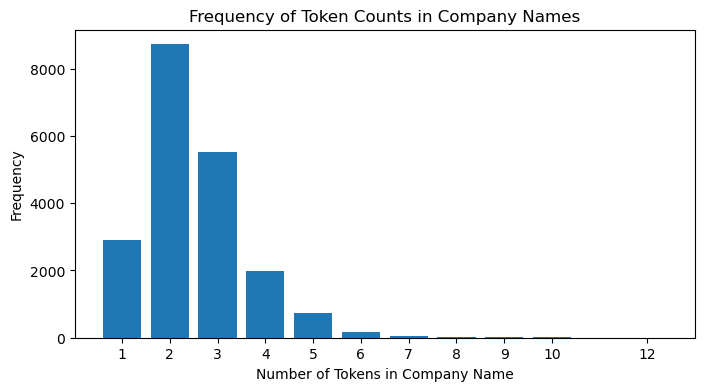

In [19]:
# Check the normal length of company names (see what is the N in N-grams)
# Maybe good enough to just check until trigrams for company name fuzzy search
company_df = pd.DataFrame(companies)
company_df.columns = ["name"]
company_df['name_length'] = company_df["name"].str.split().str.len()

# Count frequency of each token_count value
freq = company_df["name_length"].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(freq.index, freq.values)
plt.xticks(freq.index)  # exact integer ticks
plt.xlabel("Number of Tokens in Company Name")
plt.ylabel("Frequency")
plt.title("Frequency of Token Counts in Company Names")
plt.show()

In [101]:
# Export out cleaned data to check gazatteer quality
# company_df.to_csv('company_1.csv', index=False)

In [21]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65076 entries, 0 to 65076
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   job_id                65076 non-null  int64 
 1   job_title             65076 non-null  object
 2   company               65076 non-null  object
 3   descriptions          65076 non-null  object
 4   State                 65076 non-null  object
 5   merged_category       65076 non-null  object
 6   category              65076 non-null  object
 7   subcategory           65076 non-null  object
 8   role_clean            65076 non-null  object
 9   type_clean            65076 non-null  object
 10  salary                29580 non-null  object
 11  processed_title+desc  65076 non-null  object
 12  processed_text        65076 non-null  object
 13  company_clean         65076 non-null  object
dtypes: int64(1), object(13)
memory usage: 7.4+ MB


# Build TF-IDF + Cosine Similarity Doc Retrieval Pipeline

In [23]:
# Prepare a text field for indexing
# Try using processed_title+desc field first, the others (e.g. State, merged_category, role_clean, type_clean is for our filters)
doc_ids = jobs_df["job_id"].tolist()

tokenized_docs = [doc.split() for doc in jobs_df["processed_title+desc"]]

## Build TF-IDF Vectors from Corpus  
Follow example code given in https://radimrehurek.com/gensim/models/tfidfmodel.html to build TF-IDF Embeddings

In [25]:
# Import required packages
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [27]:
# Build dictionary
dct = Dictionary(tokenized_docs)

In [29]:
# Extract the frequency of each word in the corpus
doc_freq = [(dct[id], freq) for id, freq in dct.dfs.items()]
freq_df = pd.DataFrame(doc_freq, columns=["token", "doc_freq"]).sort_values("doc_freq", ascending=False)

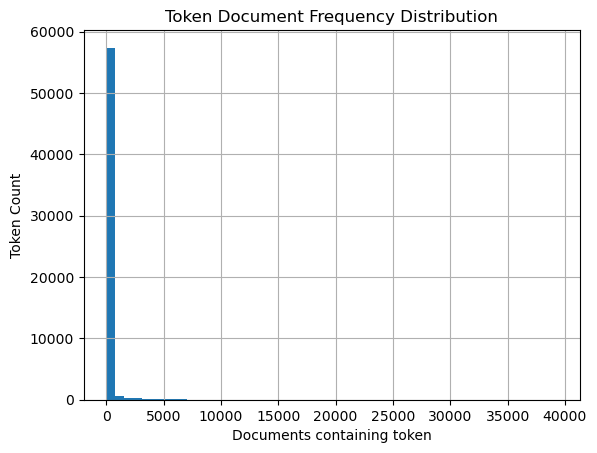

In [31]:
# Plot histogram to see proportion of rare vs common words
## Rare words are those that have few documents containing them (left side of x axis)
## Common words are those that have lots of documents containing them (right side of x axis)
## We can see that we have lots of rare words, which is good for document retrieval
## We might want to remove the common words from our Dictionary vocabulary as they will return in most of our search results
freq_df["doc_freq"].hist(bins=50)
plt.xlabel("Documents containing token")
plt.ylabel("Token Count")
plt.title("Token Document Frequency Distribution")
plt.show()

In [84]:
# Frequent words are a combination of stop words but further down it gets less generic
# Most frequent words appear in 60% of the documents
# Can remove all words up to "able" (23548 docs / 65872 docs = 0.36)
pd.set_option('display.max_rows', None)
print(freq_df.head(100))

              token  doc_freq
45             team     39740
8        management     37137
117         related     33918
245         working     33285
316   communication     32810
67           report     30380
125        business     30233
12          support     28427
94          service     27864
280        customer     26812
127        relevant     26221
14          process     26134
262        required     25777
249         ability     24788
528          system     24566
118           field     24024
41             time     23974
328     information     23805
525            role     23642
254            able     23548
688     development     22650
91          product     22409
136         english     22283
112   qualification     22152
25         maintain     22085
503         project     22007
824     description     21882
348        industry     21168
131     environment     20815
5            manage     20689
474            task     20663
194           least     20531
166       

In [85]:
# rare words are actually mispellings
print(freq_df.tail(100))

                       token  doc_freq
40055                 searix         1
40208                   jela         1
40173                derwent         1
40170                   elaw         1
40169             mewahgroup         1
40167                  dmiss         1
16882                   evdo         1
40162           oppurtunitie         1
40160          cemprehensive         1
40159              exisiting         1
40158             devolpment         1
16883                   hspa         1
40154  etimemanagementsystem         1
16884                  wimax         1
40152                  macap         1
40150        onlyshortlisted         1
16886                   rask         1
16902                  xpats         1
16903          healthmetrics         1
16911                 marhun         1
40142                   gdoc         1
40141                    biq         1
16918                digadai         1
40139         marketersmedia         1
40171                 clj

In [86]:
# Find where's the best cut off, inspect via Excel
# From inspection, after freq 5 onwards, the words have less mispellings and Malay words
rare_df = freq_df[freq_df["doc_freq"] <= 10].sort_values("doc_freq")
rare_df.to_csv("rare_tokens.csv", index=False)

In [87]:
# Reset back setting
pd.reset_option('display.max_rows')

In [33]:
# Prune extremes based on EDA above
dct.filter_extremes(no_below=5, no_above=0.36)

In [35]:
# Check no. of words in dictionary now after filtering the noise
len(dct)

21265

In [37]:
#save dictionary 
with open(os.path.join(output_directory, 'dct.pkl'), 'wb') as file:
    pickle.dump(dct, file)

In [39]:
# BoW corpus
corpus_bow = [dct.doc2bow(tokens) for tokens in tokenized_docs]

# Fit TF-IDF model
model = TfidfModel(corpus=corpus_bow)

# Transform corpus to TF-IDF
corpus_tfidf = model[corpus_bow]

In [41]:
# Save model with pkl
with open(os.path.join(output_directory, 'tfidf_model.pkl'), 'wb') as file:
    pickle.dump(model, file)

# Save corpus_tfidf with pkl
with open(os.path.join(output_directory, 'corpus_tfidf.pkl'), 'wb') as file:
    pickle.dump(corpus_tfidf, file)

## Build inverted index

In [43]:
import math
from collections import defaultdict

In [45]:
# Find out words in dictionary and their IDs in the dictionary
# This will help convert the word in the user's search query, into integer ID later for fast retrieval of candidate docs
vocab = dct.token2id

In [47]:
# Save vocab  with pkl
with open(os.path.join(output_directory, 'vocab.pkl'), 'wb') as file:
    pickle.dump(vocab, file)

In [49]:
# Positional postings: is the inverted index
## It's a dictionary of this structure: vocab_id -> [(doc_idx, [positions]), (doc_idx, [positions])]
## This tells you for each word, which docs have it, and what positions inside the doc

postings = defaultdict(list) # Creates empty dictionary

for i, toks in enumerate(tokenized_docs): # for each document id, tokens in the tokenized docs
    pos_map = defaultdict(list)
    for pos, w in enumerate(toks): # for each token and its position in the doc
        tid = vocab.get(w) # get its vocab ID from the vocab Dict above
        if tid is not None: # if word is found
            pos_map[tid].append(pos) # track this vocab ID and its position in the pos_map of the document
    for tid, positions in pos_map.items(): # After finish reading thru all tokens in the doc, take each tid-position pair
        postings[tid].append((i, positions)) # update to the overall 

In [51]:
# Save inverted_index  with pkl
with open(os.path.join(output_directory, 'inverted_index.pkl'), 'wb') as file:
    pickle.dump(postings, file)

In [58]:
# Testing finding 'administration' (vocab ID = 7)
postings[7]

[(0, [16]),
 (4, [163]),
 (7, [5]),
 (9, [23, 32]),
 (14, [59]),
 (15, [75]),
 (17, [75, 79, 88]),
 (20, [19]),
 (24, [3]),
 (26, [73]),
 (29, [135]),
 (32, [152]),
 (36, [191]),
 (41, [175]),
 (43, [205]),
 (46, [95]),
 (54, [69, 121, 124]),
 (55, [105]),
 (57, [95, 96]),
 (70, [420]),
 (71, [112]),
 (80, [88]),
 (83, [2, 125, 140, 147, 163, 233]),
 (85, [122]),
 (88, [223]),
 (93, [98]),
 (94, [52]),
 (95, [7, 106, 121]),
 (97, [72]),
 (102, [56]),
 (103, [126]),
 (106, [146]),
 (107, [152]),
 (112, [34, 77, 203]),
 (113, [0, 10, 31, 42]),
 (115, [43]),
 (118, [82, 114]),
 (123, [93]),
 (124, [22, 31, 294, 520]),
 (128, [48]),
 (129, [39]),
 (130, [28, 69]),
 (132, [35, 51]),
 (133, [102, 126]),
 (134, [6]),
 (136, [166]),
 (137, [54]),
 (140, [183]),
 (142, [271, 276]),
 (153, [141, 146]),
 (154, [174]),
 (155, [3]),
 (156, [87]),
 (158, [24]),
 (160, [123]),
 (163, [49]),
 (168, [22]),
 (169, [14, 67, 119, 128, 164]),
 (170, [1]),
 (173, [73, 185]),
 (175, [130]),
 (176, [65]),
 (1

In [60]:
# Validate using Doc 0, 16th position
tokenized_docs[0]

['procurement',
 'executive',
 'contract',
 'position',
 'purpose',
 'manage',
 'aspect',
 'procurement',
 'supplier',
 'management',
 'contract',
 'management',
 'vendor',
 'performance',
 'tracking',
 'support',
 'administration',
 'management',
 'procurement',
 'process',
 'includes',
 'setting',
 'maintaining',
 'administering',
 'purchasing',
 'database',
 'developing',
 'issuing',
 'purchase',
 'order',
 'maintain',
 'contract',
 'log',
 'providing',
 'support',
 'department',
 'within',
 'organization',
 'involved',
 'procurement',
 'key',
 'duty',
 'general',
 'po',
 'created',
 'following',
 'bidding',
 'oa',
 'update',
 'time',
 'time',
 'upon',
 'request',
 'planning',
 'team',
 'buyer',
 'geographical',
 'coverage',
 'singapore',
 'operation',
 'purchasing',
 'activity',
 'comply',
 'procurement',
 'procedure',
 'internal',
 'policy',
 'actively',
 'seek',
 'opportunity',
 'improvement',
 'way',
 'thing',
 'better',
 'lead',
 'implementation',
 'action',
 'defined',
 'manag

## Create Categorical Filters

In [53]:
# list all values in each of the categorical fields we are using for filter in Series format
state_arr = jobs_df["State"].astype(str).values
type_arr = jobs_df["type_clean"].values
merged_category_arr = jobs_df["merged_category"].astype(str).values

N = len(tokenized_docs) # Size of the corpus

In [55]:
N

65076

In [57]:
# Assume data passed in already has validity checks on Front End
def facet_mask(state=None, job_type=None, merged_category=None):
    m = np.ones(N, dtype=bool) # Initialise an array m of all True first, assume no filters added
    if state is not None: # check if a filter was used by the user, if there is a value passed in      
        m &= (state_arr == str(state)) # check docs that fulfil the user's passed in value, reassign back to mask m
    if job_type is not None:
        if isinstance(job_type, list) and len(job_type) > 0: 
            # normalize case once
            sel = [s.lower() for s in job_type]
            m &= np.fromiter(
                (any((t.lower() in sel) for t in type_arr[i]) for i in range(N)),
                dtype=bool,
                count=N
            )
    if merged_category is not None:    
        m &= (merged_category_arr == str(merged_category))
    return m

## Query parsing

The user's query will pass through 2 separate steps, company extraction and query expansion

### Company Extraction

Try to find company names (if any) in the query. Company extraction has very different signals and we need to wipe out the role related keywords in order to find the entity, and extra terms introduced during query expansion may dirty the company name data, so the logic directly conflicts with the query expansion logic below.

In [59]:
# M'sian company names only allow letters, numbers, &, period, hyphen, ', ()
# But the useful ones are letters, numbers, & (convert to 'and')
def light_normalize(text):
    s = text.lower()
    s = re.sub(r"[^a-z0-9\s&]", " ", s) # Keep only useful characters
    s = s.replace("&", " and ") # replace & with and, similar treatment as company gazatteer
    s = re.sub(r"\s+", " ", s).strip() # collapse multiple white space if any
    return s

In [61]:
# Check for simple event template
event_pat = re.compile(r'\b(?:at|with|for|from)\s+([a-z0-9 ]{2,})$', re.I)

def event_pat_search(text):
    m = event_pat.search(text)
    return [m.group(1)] if m else []

In [63]:
# Define role stop words (this is different from the normal stop words. e.g. procurement executive apple, 
# we want 'procurement executive' to be cleaned off because these are words not used in company names)
# Cannot clean off location words as could be part of the company name (e.g. Royal Selangor Association), except "Malaysia"

# Create keyword processor using FlashText (which is a phrase matcher)
# Throw in all the role_clean values inside since it's very comprehensive, act as role_stopwords
role_keyword_processor = KeywordProcessor(case_sensitive=False)
role_keyword_list = jobs_df['role_clean'].str.lower().str.strip().dropna().tolist()
for p in role_keyword_list:
    if p:  # avoid empty strings
        role_keyword_processor.add_keyword(p, " ") # FlashText to replace with empty space (empty string doesnt work) when these phrases found

In [65]:
# Still add some custom stop words which are one-word to prevent more unintended matches to company names
# Intended result: No company matches, become general search with no company name filter.
role_stopwords = {
    "intern", "internship", "role", "roles", "job", "jobs", "position", "positions", 
    "career", "careers", "vacancy", "vacancies", "lead", "senior", "junior",
    "remote", "hybrid", "office", "hiring", "malaysia", "analyst", "scientist", "executive",
    "manager", "engineer", "developer"
}

stop_words = set(stopwords.words("english"))
role_stopwords |= stop_words # Try to remove so it will cut down on the no. of N-grams formed

# N-gram sweep required for query cases with no prepositions, like "Apple jobs", "Shopee data scientist"
# Max use trigrams because majority of company names are 3 words
def ngram_sweep(text, n_max=3):
    cleaned_text = role_keyword_processor.replace_keywords(text)
    toks = [t for t in cleaned_text.split() if t not in role_stopwords]
    cands = set()
    for n in range(1, n_max+1): # extract unigram (0-1st pos), till trigram (0-4th pos). total 6 combis
        for i in range(len(toks) - n+1):
            cands.add(" ".join(toks[i:i+n]))
    return sorted(cands, key=lambda x: (-len(x.split()), -len(x))) # sort longer N-grams first

In [67]:
def extract_companies(text):
    s = light_normalize(text)
    cand_companies = list(set(event_pat_search(s) + ngram_sweep(s))) # Get all possible company names from the 2 methods
    return cand_companies

In [69]:
# Test some queries
queries = [
    "maybank jobs",
    "jobs at apple",
    "google internship malaysia",
    "senior analyst roles at malayan banking",
    "apple singapore office hiring",
    "marketing jobs",
    "social media executive"
]

for q in queries:
    print(q, "→", extract_companies(q))

maybank jobs → ['maybank']
jobs at apple → ['apple']
google internship malaysia → ['google']
senior analyst roles at malayan banking → ['banking', 'malayan banking', 'malayan']
apple singapore office hiring → ['apple', 'singapore', 'apple singapore']
marketing jobs → []
social media executive → []


### Query Parsing and Expansion
Process the query in the same way as the documents in the corpus. Which includes the overall cleaning logic by Snekha

In [71]:
# import packages to re-use functions used in cleaning text for database
import re
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.wsd import lesk

'''
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
'''

def normalize_text(text):
    text = re.sub(r'<.*?>', ' ', text)                     # remove HTML tags
    text = re.sub(r'\\n|\n', ' ', text)                    # remove newlines
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)            # keep letters & numbers only
    text = text.lower()                                    # lowercase
    text = re.sub(r'\s+', ' ', text).strip()               # normalize spaces
    return text

stop_words = set(stopwords.words("english"))
custom_stop = {"experience","responsibilities","requirements","requirement","knowledge",
    "skill","skills","advantage","preferred","strong","good","excellent",
    "degree","diploma","bachelor","graduate","title",
    "independent","self-motivated","hardworking",
    "deadline","pressure","benefits","apply","immediately", "writing","spoken","etc","others","job","work","company",
    "candidate","menu","new","plus","years","revenue","ensure", "provide", "including", "malaysia"}
stop_words |= custom_stop
stop_words |= set(stopwords.words("indonesian")) # unable to find malay stopword, hence using indonasian which is relatively close
lemmatizer = WordNetLemmatizer()

# get POS tagging
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None
    
def expand_query(text):
    sentences = sent_tokenize(text)
    words= []
    pos_tags=[]
    
    for sent in sentences:
        w = word_tokenize(sent)  
        words+=w
        tags=pos_tag(w) 
        pos_tags+=tags 
                        
    expanded_queries = []
    for word, pos in zip(words, pos_tags):
        pos = get_wordnet_pos(pos[1])
        synsets = wordnet.synsets(word, pos=pos)
        if synsets:
            correct_synset = lesk(words, word, pos=pos)
            if correct_synset:
                max_similarity = 0
                most_similar_synset = None
                for synset in synsets:
                    similarity = correct_synset.path_similarity(synset)
                    if similarity and similarity > max_similarity:
                        max_similarity = similarity
                        most_similar_synset = synset
                if most_similar_synset:
                    expanded_queries+=most_similar_synset.lemma_names()
            else:
                expanded_queries.append(word)
        else:
            expanded_queries.append(word)

    tokens=[]

    #include cleaning steps used to clean original database
    for word in expanded_queries: 
        w=normalize_text(word)
        if w.isalpha() and w not in stop_words:        
            lemma = lemmatizer.lemmatize(w)           
            tokens.append(lemma)

    return tokens

In [73]:
# text query expansion test
expand_query("fiscal policy and compliance analyst")

['fiscal',
 'financial',
 'policy',
 'insurance',
 'submission',
 'compliance',
 'analyst']

## Build candidate set

In [75]:
# Special helper function to fuzzy match candidate company names to the company gazatteer (companies)
def best_company(cand_companies, companies, cutoff=80):
    matches = [] # keep track of all successful fuzzy matches
    for cand in cand_companies: # feed all the possible candidates 
        if not cand:
            continue
            
        hits = process.extract( 
            cand,
            companies,
            scorer=fuzz.token_set_ratio
        )
        
        # keep only those >= cutoff
        for name, score, _ in hits:
            if score >= cutoff:
                # Append entire info (for troubleshooting mode)
                # matches.append({
                #     "cand": cand,
                #     "matched_company": name,
                #     "score": float(score)
                # })

                matches.append(name)
            
    return matches # Note: may be empty list

In [235]:
# # Test queries in troubleshoot mode (seems like the unigrams will result in lots of slightly less relevant matches, but at least wont accidentally filter)
# test_query = ['malayan banking', 'banking', 'malayan']
# print(best_company(test_query, companies))

[{'cand': 'malayan banking', 'matched_company': 'malayan banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'al rajhi banking and investment corporation', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal cfs personal and premier banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal cfs premier banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal wb corporate and commercial banking', 'score': 100.0}, {'cand': 'banking', 'matched_company': 'mal wb enterprise banking', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan adhesives and chemicals', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan banking', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan energistik solutions', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan flour mills', 'score': 100.0}, {'cand': 'malayan', 'matched_company': 'malayan racing association', 'score': 100.0}]


In [87]:
# Test query in non troubleshoot mode
# test_query = ['malayan banking', 'banking', 'malayan']
# print(best_company(test_query, companies))

['malayan banking', 'al rajhi banking and investment corporation', 'mal cfs personal and premier banking', 'mal cfs premier banking', 'mal wb corporate and commercial banking', 'mal wb enterprise banking', 'malayan adhesives and chemicals', 'malayan banking', 'malayan energistik solutions', 'malayan flour mills', 'malayan racing association']


In [77]:
def candidate_docs(query, state=None, job_type=None, merged_category=None):
    cand_companies = extract_companies(query)
    keywords = expand_query(query)

    # 1) Apply facet mask first to quickly reduce no. of documents to do keyword match on
    m = facet_mask(state=state, job_type=job_type, merged_category=merged_category)
    allowed_idx = np.flatnonzero(m) # returns indices where facet_mask is True
    allowed_set = set(allowed_idx) # Reduced candidate set for later

    # 2) Company filtering inside allowed_set. Strategy is to intersect allowed_set with company_set
    company_matches = best_company(cand_companies, companies, cutoff=80)
    if company_matches: # if there are results proceed to filter
        company_set = set(jobs_df.index[jobs_df['company_clean'].isin(company_matches)])
        allowed_set_intersect = allowed_set.intersection(company_set)
        # Only if there is intersection then we use the intersected set, else continue to use allowed_set
        if allowed_set_intersect:
            allowed_set = allowed_set_intersect  # use intersection
    
    # 3) Collect keyword candidates using inverted index, only keep docs in allowed_set
    cand = set()
    if keywords:
        for w in keywords:
            tid = vocab.get(w) # check if word in my vocab dictionary
            if tid is None: # Not found, ignore
                continue
            for d, _ in postings[tid]: # if found, get the document id
                if d in allowed_set:         # check if this doc id was in the reduced candidate set already
                    cand.add(d) # If it is, add to the set() called cand
    else:
        # No keywords: candidates are all postings based on categorical filters. 
        cand = set(allowed_idx)

    return np.array(sorted(cand), dtype=int)

In [79]:
# Test candidate_docs function
candidate_docs(query='senior analyst roles at malayan banking')

array([  535,   996,  1287,  1526,  1680,  4478,  4799,  5153,  5781,
        6153,  6154,  6155,  6156,  6293,  6604,  6795,  8423, 10168,
       11504, 11688, 11753, 11775, 11907, 11917, 12054, 12080, 12164,
       12420, 12448, 12470, 12603, 12928, 13026, 13554, 13738, 13963,
       14047, 14335, 14506, 14651, 14747, 14838, 14992, 15015, 15025,
       15073, 15156, 15316, 15433, 15441, 15491, 15574, 15688, 15716,
       15726, 15840, 15881, 16005, 16115, 16133, 16213, 16301, 16355,
       16463, 17034, 17209, 18047, 19013, 19482, 20337, 20699, 21226,
       21253, 21566, 21713, 22349, 22497, 22522, 23041, 23161, 23242,
       23931, 23992, 23993, 24086, 24410, 25477, 25937, 26373, 27990,
       30600, 30918, 31062, 31878, 32336, 32530, 32843, 33041, 33089,
       33106, 37782, 40359, 42139, 42427, 42539, 43629, 44628, 44658,
       44696, 44803, 44848, 45354, 47857, 47909, 48118, 48179, 48188,
       48259, 48265, 48394, 48476, 48667, 48727, 48756, 50807, 51663,
       53282, 55636,

In [81]:
# Random pick one of the jobs to see if its relevant to the company somewhat
jobs_df.iloc[12470]

job_id                                                           72917161
job_title                Premier Banking - Relationship Manager (Kuantan)
company                               MAL CFS - Premier Banking (Kuantan)
descriptions            Description\nRoles & Responsibilities\nWhat yo...
State                                                              Pahang
merged_category                                      Accounting & Finance
category                                     Banking & Financial Services
subcategory                                               Client Services
role_clean                                   Banking Relationship Manager
type_clean                                                    [full time]
salary                                                                NaN
processed_title+desc    premier banking relationship manager kuantan d...
processed_text          premier banking relationship manager kuantan m...
company_clean                         

## Score candidates with TF-IDF cosine

In [83]:
from collections import Counter
from gensim import similarities

def rank_tfidf_cosine(query, k=10, state=None, job_type=None, merged_category=None):
    # Fetch the index positions of the candidate documents
    cand_idx = candidate_docs(query, state=state, job_type=job_type, merged_category=merged_category)
    if len(cand_idx) == 0:
        return jobs_df.iloc[[]] # return nothing

    # Convert the query into BoW then TF-IDF (using existing Dictionary + TfidfModel)
    q_tokens = expand_query(query)
    q_bow = dct.doc2bow(q_tokens)
    q_tfidf = model[q_bow]          

    # Build a similarity index over ONLY the candidates
    cand_corpus_tfidf = [corpus_tfidf[i] for i in cand_idx] # Fetch the candidate TF-IDFs into a list
    index = similarities.SparseMatrixSimilarity(
        cand_corpus_tfidf, # only candidate TF-IDFs
        num_features=len(dct)   # use dictionary size
    )

    # Compute cosine similarities of query vs candidate docs
    sims = index[q_tfidf] # returns a list of cosine similarity scores, 0 indexed
    doc_scores = list(zip(cand_idx, sims)) # zip candidate index to the sim score
    doc_scores.sort(key=lambda x: x[1], reverse=True) # sort by sim score, desc order
    topk = doc_scores[:k] # take top k scores 
    top_doc_idx = [doc_id for doc_id, _ in topk] # Extract the candidate index and similarity score separately
    top_scores  = [score  for _, score in topk]

    # fetch original doc from jobs_df
    out = jobs_df.iloc[top_doc_idx].copy()
    out['score'] = top_scores # Append score for reference
    out = out.sort_values(by='score', ascending=False)
    return out

# Example usage

In [85]:
result = rank_tfidf_cosine(
    "procurement executive",
    k=10,
    state="Selangor",
    job_type=['Full time'],
    merged_category="Accounting & Finance"
)

result[['job_id', 'job_title', 'descriptions', 'State', 'type_clean', 'merged_category', 'score']]

,job_id,job_title,descriptions,State,type_clean,merged_category,score
57956,83069304,Account Senior Executive (Hiap Cheng Trading &...,Job Scoop:\nPost and process journal entries t...,Selangor,[full time],Accounting & Finance,0.264524
17420,74045512,Accounts Cum Procurement Executive,Account Role:\nOrganize the bookkeeping proces...,Selangor,[full time],Accounting & Finance,0.239858
1692,74561969,Accounts Executive,Qualifications & Experience\nCandidate must po...,Selangor,[full time],Accounting & Finance,0.161215
63792,84001797,Accounts Executive,Responsibilities:\nMonitor collection and rece...,Selangor,[full time],Accounting & Finance,0.151841
49669,76229436,Account and Admin Executive,Job Description:\nWe are seeking a motivated a...,Selangor,[full time],Accounting & Finance,0.139191
56849,83238939,Procurement Manager (Direct category),"At Suntory, we recognize that diverse knowledg...",Selangor,[full time],Accounting & Finance,0.138525
10545,74170841,"Senior Executive, Commercial",Objective:\nResponsible for overseeing and coo...,Selangor,[full time],Accounting & Finance,0.138445
5661,74389917,ACCOUNTANT,Key Responsibilities:\n● Supervising acc...,Selangor,[full time],Accounting & Finance,0.121199
44965,75950438,ACCOUNT CUM ADMIN CLERK,Account Clerks manage accounts and provide sup...,Selangor,[full time],Accounting & Finance,0.119905
16683,74086436,Senior Finance Executive,Job Description:\nDevelop and implement financ...,Selangor,[full time],Accounting & Finance,0.118823


In [87]:
# Test company fuzzy search with preposition (event template will pick this up)
result = rank_tfidf_cosine(
    "senior analyst roles at maybank",
    k=10,
    state="Kuala Lumpur",
    job_type=['Full time']
)

result[['job_id', 'company', 'job_title', 'descriptions', 'score']]

,job_id,company,job_title,descriptions,score
35708,75021045,Michael Page International (Malaysia) Sdn Bhd,Technical Project Manager,"Co-solutions, manages and delivers IT Projects...",0.324981
15216,72996785,Malayan Banking Berhad (Maybank),Global Maybank Apprentice Programme (GMAP),An engineer? A lawyer? We accept graduates fro...,0.276760
42539,75638168,Malayan Banking Berhad (Maybank),Relationship Manager - Maybank Ventures,Responsibilities:\nProvide recommendation to M...,0.263943
63575,83419476,Malayan Banking Berhad (Maybank),"Lead, Trade Finance","To spearhead, oversee, provide directions, gui...",0.219905
59157,83016234,Malayan Banking Berhad (Maybank),Driver for Management Team,Driver home based in either Nilai/Seremban/Tam...,0.207192
40026,75619634,LIYING MARKETING SDN BHD,Data Analyst - Remote / 数据分析师 - 线上,岗位职责：\n根据数据分析结果提出相关的建议给客户提供决策，能够快速进入购买兑换价格。\n职...,0.203593
3775,74266622,Joey Yap Research International,System Analyst/ IT Business Analyst,Job Scope\nCollaborate with stakeholders to ga...,0.181855
42841,75636852,Malayan Banking Berhad (Maybank),HouzKey Consultant- Maybank Ventures,Responsibilities:\nSupport Manager in the sale...,0.178649
44696,75869530,Malayan Banking Berhad (Maybank),CONSUMER SALES EXECUTIVE - FEDERAL TERRITORY,To carry out sales activities to increase sale...,0.177626
11728,73239451,Loanstreet,Analyst cum QA,Analyst cum QA\nYour role will be to:\nInitiat...,0.175377


In [89]:
# Test company fuzzy search without preposition (n-gram sweep will pick this up)
result = rank_tfidf_cosine(
    "google engineer",
    k=10
)

result[['job_id', 'company', 'job_title', 'descriptions', 'score']]

,job_id,company,job_title,descriptions,score
13069,74166152,Google Malaysia Sdn Bhd,"Field Sales Representative, Google Cloud",Qualification\nMinimum qualifications:\nBachel...,0.584904
12307,73986161,Google Malaysia Sdn Bhd,"Sales Specialist, Google Workspace",Qualification\nMinimum qualifications:\nBachel...,0.552865
23335,74457851,Google Malaysia Sdn Bhd,"Customer Solutions Consultant, Infrastructure ...",Qualification\nMinimum qualifications:\nBachel...,0.351743
20815,74641866,Google Malaysia Sdn Bhd,"Electrical Engineer, Data Center Design and Co...",Qualification\nMinimum qualifications:\nMaster...,0.129047


In [91]:
# Test general search term, whether will confuse as company name
# This query will be confused as company name as there isnt any role found (unlike "social media executive" below)
# There wont be good results because very few companies have name 'social', 'media', 'social' media which have
# "social media" in job title and description
result = rank_tfidf_cosine(
    "social media",
    k=10   
)

result[['job_id', 'job_title', 'company', 'descriptions', 'State', 'type_clean', 'merged_category', 'score']]

,job_id,job_title,company,descriptions,State,type_clean,merged_category,score
59083,83280378,Social Media Marketing Executive,Tong Garden Food (Malaysia) Sdn Bhd,"We are looking for a creative, detail-oriented...",Johor,[full time],Sales & Marketing,0.126606


In [93]:
# This query should have no issue, coz the role is entirely cleaned away by FlashText
result = rank_tfidf_cosine(
    "social media executive",
    k=10   
)

result[['job_id', 'job_title', 'company', 'descriptions', 'State', 'type_clean', 'merged_category', 'score']]

,job_id,job_title,company,descriptions,State,type_clean,merged_category,score
53059,76504421,SOCIAL MEDIA SENIOR MANAGER,BnBC Advertising Sdn Bhd,We are an established creative communications ...,Selangor,[full time],Creative & Design,0.303672
35449,74986907,Social Media Senior Executive,Loob Holding Sdn Bhd,Overview:\nAs the Senior Social Media Executiv...,Selangor,[full time],Creative & Design,0.287659
36631,75299476,Social Media Specialist,Sri Borneo Paradise Sdn Bhd,Qualifications & experience\nMinimum 2 years\n...,Sabah,[full time],Sales & Marketing,0.285270
34639,75011832,Social Media Executive,SUNFERT INTERNATIONAL FERTILITY CENTRE SDN BHD,Job Purpose\nTo manage Sophea's (under Sunfert...,Kuala Lumpur,[contract/temp],Sales & Marketing,0.283900
31073,74912888,SOCIAL MEDIA STRATEGIST,BnBC Advertising Sdn Bhd,We are an established creative communications ...,Selangor,[full time],Sales & Marketing,0.282942
36369,75231803,SOCIAL MEDIA & MARKETING COORDINATOR,Moonlight Manufacturing Sdn Bhd,"Manage customer inquiries, feedback, and compl...",Johor,[full time],Sales & Marketing,0.278135
43396,75702036,Head of Social Media Unit,MyFundAction,Key Responsibilities:\nKey Responsibilities:\n...,Selangor,[full time],Sales & Marketing,0.277897
35371,74995368,Social Media Executive,ASER SOCIAL MEDIA MARKETING,We are excited to welcome a dynamic and innova...,Johor,[full time],Sales & Marketing,0.274869
41224,75549063,Social Media Executive,Doo Group,Job Description:\nResponsible for social media...,Kuala Lumpur,[full time],Sales & Marketing,0.274811
47951,76287205,Social Media Executive,MumsMe Sdn Bhd,MumsMe is currently looking for TALENTS like y...,Johor,[full time],Sales & Marketing,0.273441
